In [2]:
pip install seaborn

  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
  Obtaining dependency information for pandas>=0.25 from https://files.pythonhosted.org/packages/ed/30/b97456e7063edac0e5a405128065f0cd2033adfe3716fb2256c186bd41d0/pandas-2.0.3-cp310-cp310-win_amd64.whl.metadata
  Using cached pytz-2023.3-py2.py3-none-any.whl (502 kB)
  Using cached tzdata-2023.3-py2.py3-none-any.whl (341 kB)
   ---------------------------------------- 0.0/10.7 MB ? eta -:--:--
    --------------------------------------- 0.2/10.7 MB 11.5 MB/s eta 0:00:01
   ----- ---------------------------------- 1.4/10.7 MB 15.0 MB/s eta 0:00:01
   ---------- ----------------------------- 2.8/10.7 MB 24.9 MB/s eta 0:00:01
   ------------ --------------------------- 3.4/10.7 MB 17.9 MB/s eta 0:00:01
   ------------------- -------------------- 5.2/10.7 MB 23.6 MB/s eta 0:00:01
   --------------------- ------------------ 5.8/10.7 MB 20.5 MB/s eta 0:00:01
   ------------------------------ --------- 8.2/10.7 MB 24.9 MB/s eta 0:00:01


In [3]:
from transformers import BartForConditionalGeneration, PreTrainedTokenizerFast
from transformers.optimization import get_cosine_schedule_with_warmup
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import json


In [4]:
class DatasetFromDataframe(Dataset):
    def __init__(self, df, dataset_args):
        self.data = df
        self.max_length = dataset_args['max_length']
        self.tokenizer = dataset_args['tokenizer']
        self.start_token = '<s>'
        self.end_token = '</s>'

    def __len__(self):
        return len(self.data)
    
    def create_tokens(self, text):
        tokens = self.tokenizer.encode(self.start_token + text + self.end_token)
        
        tokenLength = len(tokens)
        remain = self.max_length - tokenLength
        
        if remain >= 0:
            tokens = tokens + [ self.tokenizer.pad_token_id ] * remain
            attention_mask = [ 1 ] * tokenLength + [ 0 ] * remain
        else:
            tokens = tokens[: self.max_length - 1] + self.tokenizer.encode(self.end_token)
            attention_mask = [ 1 ] * self.max_length
        
        return tokens, attention_mask

    def __getitem__(self, index):
        record = self.data.iloc[index]

        question, answer = record['input_text'], record['target_text']
        
        input_id, input_mask = self.create_tokens(question)
        output_id, output_mask = self.create_tokens(answer)
        
        label = output_id[1:(self.max_length + 1)]
        label = label + (self.max_length - len(label)) * [ -100 ]
        
        return {
            'input_ids': torch.LongTensor(input_id),
            'attention_mask': torch.LongTensor(input_mask),
            'decoder_input_ids': torch.LongTensor(output_id),
            'decoder_attention_mask': torch.LongTensor(output_mask),
            "labels": torch.LongTensor(label)
        }

In [5]:
class OneSourceDataModule(pl.LightningDataModule):
    def __init__(
        self,
        **kwargs
    ):
        super().__init__()
        
        self.data = kwargs.get('data')
        self.dataset_args = kwargs.get("dataset_args")
        self.batch_size = kwargs.get("batch_size") or 32
        self.train_size = kwargs.get("train_size") or 0.9

    def setup(self, stage = ""):
        trainset, testset = train_test_split(df, train_size=self.train_size, shuffle=True)
        
        self.trainset = DatasetFromDataframe(trainset, self.dataset_args)
        self.testset = DatasetFromDataframe(testset, self.dataset_args)

    def train_dataloader(self):
        train = DataLoader(
            self.trainset,
            batch_size=self.batch_size
        )
        return train

    def val_dataloader(self):
        val = DataLoader(
            self.testset,
            batch_size=self.batch_size
        )
        return val

    def test_dataloader(self):
        test = DataLoader(
            self.testset,
            batch_size=self.batch_size
        )
        return test

In [6]:
class KoBARTConditionalGeneration(pl.LightningModule):
    def __init__(self, hparams, **kwargs):
        super(KoBARTConditionalGeneration, self).__init__()
        self.hparams.update(hparams)
        
        self.model = kwargs['model'].cuda()
        self.tokenizer = kwargs['tokenizer']
        
        self.model.train()

    def configure_optimizers(self):
        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        
        optimizer_grouped_parameters = [{
            'params': [
                p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
            ],
            'weight_decay': 0.01
        }, {
            'params': [
                p for n, p in param_optimizer if any(nd in n for nd in no_decay)
            ],
            'weight_decay': 0.0
        }]
        
        optimizer = torch.optim.AdamW(
            optimizer_grouped_parameters,
            lr = self.hparams.lr
        )
        
        # num_workers = gpus * num_nodes
        data_len = len(self.train_dataloader().dataset)
        print(f'학습 데이터 양: {data_len}')
        
        num_train_steps = int(data_len / self.hparams.batch_size * self.hparams.max_epochs)
        print(f'Step 수: {num_train_steps}')
        
        num_warmup_steps = int(num_train_steps * self.hparams.warmup_ratio)
        print(f'Warmup Step 수: {num_warmup_steps}')
        
        scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=num_warmup_steps,
            num_training_steps=num_train_steps
        )
        
        lr_scheduler = {
            'scheduler': scheduler, 
            'monitor': 'loss',
            'interval': 'step',
            'frequency': 1
        }
        
        return [ optimizer ], [ lr_scheduler ]
        
    def forward(self, inputs):
        return self.model(
            input_ids = inputs['input_ids'],
            attention_mask = inputs['attention_mask'],
            decoder_input_ids = inputs['decoder_input_ids'],
            decoder_attention_mask = inputs['decoder_attention_mask'],
            labels = inputs['labels'],
            return_dict = True
        )

    def training_step(self, batch, batch_idx):
        loss = self(batch).loss
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self(batch).loss

    def test(self, text):
        tokens = self.tokenizer.encode("<s>" + text + "</s>")
        
        tokenLength = len(tokens)
        remain = self.hparams.max_length - tokenLength
        
        if remain >= 0:
            tokens = tokens + [ self.tokenizer.pad_token_id ] * remain
            attention_mask = [ 1 ] * tokenLength + [ 0 ] * remain
        else:
            tokens = tokens[: self.hparams.max_length - 1] + self.tokenizer.encode("</s>")
            attention_mask = [ 1 ] * self.hparams.max_length
        
        tokens = torch.LongTensor([ tokens ]).cuda()
        attention_mask = torch.LongTensor([ attention_mask ]).cuda()
        self.model = self.model.cuda()
        
        result = self.model.generate(
            tokens,
            max_length = self.hparams.max_length,
            attention_mask = attention_mask,
            num_beams = 10
        )[0]
        
        a = self.tokenizer.decode(result)
        return a

In [7]:
tokenizer = PreTrainedTokenizerFast.from_pretrained(
    "gogamza/kobart-base-v2",
    bos_token="<s>",
    eos_token="</s>",
    unk_token='<unk>',
    pad_token='<pad>',
    mask_token='<mask>'
)

c:\Users\Playdata\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Playdata\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The num

In [9]:
df = pd.read_csv("pair.csv")

In [18]:
df.to_csv("성경.csv",encoding='utf-8')

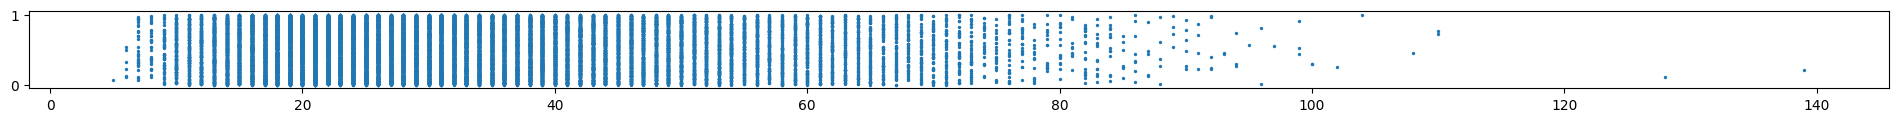

In [13]:
token_lengthes = df.apply(
    lambda row: max(
        len(tokenizer.encode(row['target_text'])),
        len(tokenizer.encode(row['input_text']))
    ),
    axis=1
)

plt.figure(figsize=(24, 1))
plt.scatter(
    token_lengthes,
    np.random.rand(len(token_lengthes)),
    s = 2
)

In [14]:
df = df.drop(
    index=df[token_lengthes > 120].index,
    axis=0
)

In [15]:
BATCH_SIZE = 32
MAX_LENGTH = 128
EPOCHS = 6

In [16]:
KoBARTModel = BartForConditionalGeneration.from_pretrained("gogamza/kobart-base-v2")

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


In [17]:
model = KoBARTConditionalGeneration({
    "lr": 5e-6,
    "warmup_ratio": 0.1,
    "batch_size": BATCH_SIZE,
    "max_length": MAX_LENGTH,
    "max_epochs": EPOCHS
},
    tokenizer = tokenizer,
    model = KoBARTModel
)

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
dm = OneSourceDataModule(
    data = df,
    batch_size = BATCH_SIZE,
    train_size = 0.9,
    dataset_args = {
        "tokenizer": tokenizer,
        "max_length": MAX_LENGTH,
    }
)

In [ ]:
trainer = pl.Trainer(
    max_epochs = EPOCHS,
    gpus = 1
)

In [ ]:
trainer.fit(model, dm)

In [ ]:
KoBARTModel.save_pretrained("./final.h5")

In [ ]:
for i in range(5):
    test = df.sample(frac=1).iloc[0]

    print(test.input_text)
    print(model.test(test.input_text))
    print(test.target_text)
    
    print("\n-----\n")

In [ ]:
model.test("이러한 덕목을 실천하기 위해서는 쉬지 않고 험난한 길이지만 꾸준하게 노력해야한다. 중요한 것은 힙한 용어를 들먹이면서 실제 문제에 대한 답변을 회피하는것이다.")